In [1]:
from train.data.supervised import ResampledAframeDataset
from ml4gw.distributions import PowerLaw
import torch
from lightning.pytorch.trainer import Trainer
from train.callbacks import ModelCheckpoint, SaveAugmentedBatch
from train.model import SupervisedAframe
from architectures.bandpass import Bandpass
from ml4gw.nn.norm import GroupNorm1DGetter
from train.metrics import TimeSlideAUROC
#from matplotlib import pyplot as plt
from lightning.pytorch.loggers import CSVLogger
import sys
sys.path.append('/home/seiya.tsukamoto/aframe/libs/priors/')
from priors.priors import end_o3_ratesandpops
import numpy as np
import os
import gc
from matplotlib import pyplot as plt
from collections import defaultdict
from torchmetrics.classification import BinaryAUROC

/usr/local/lib/python3.10/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


In [2]:
arch = Bandpass(classes = 64, num_ifos = 2, layers = [3, 4, 6, 3], norm_layer = GroupNorm1DGetter(groups = 16), 
                                  sample_rate = 2048, kernel_length = 4)
metric = TimeSlideAUROC(max_fpr = 1e-3, pool_length = 8, stride = 0.5)
weight_decay = 0.0
learning_rate = 0.000585
pct_lr_ramp = 0.115


batch_size = 10
batches_per_epoch = 10
num_files_per_batch = 10
chunk_size = 10000
chunks_per_epoch = 10
psd_length = 8
fftlength = None

waveform_prob = 0.277
swap_prob = 0.014
mute_prob = 0.055
left_pad = 0.25
right_pad = 0.05
snr_sampler = PowerLaw(minimum = 4, maximum = 100, index = -3)
valid_frac = 0.25
valid_stride = 0.5
num_valid_views = 5
valid_livetime = 10000



logger = CSVLogger(save_dir = '/home/seiya.tsukamoto/aframe/test', flush_logs_every_n_steps = 10)
callbacks = [ModelCheckpoint(monitor = "valid_auroc", mode = "max", save_top_k = 1, save_last = True, auto_insert_metric_name = False),
             SaveAugmentedBatch()]
max_epochs = 1
check_val_every_n_epoch = 1
log_every_n_steps = 20



ifos = ["H1", "L1"]
train_start = 1240579783
train_stop = 1241443783
test_stop = 1244035783 
max_duration = 10000
Tb = 31536000
shifts = [0, 1]
seed = 1122

streams_per_gpu = 6

kernel_length = [4, 2, 1]
prior = end_o3_ratesandpops

fftlength = None 
sample_rate = 2048
resample_rate = [512, 1024, 2048]
fduration = 1
highpass = [32, 64, 128]
lowpass = [64, 128, 1024]
band = 0

inference_psd_length = 64
inference_sampling_rate = 4
inference_batch_size = 128

waveform_duration = 10
coalescence_time = 8
min_valid_duration = 1000.0

data_dir = '/home/seiya.tsukamoto/aframe/layered/data/train'

In [3]:
module = SupervisedAframe(arch = arch, metric = metric, learning_rate = learning_rate, 
                          pct_lr_ramp = pct_lr_ramp, weight_decay = weight_decay, verbose = True)

In [4]:
RSAD = ResampledAframeDataset(data_dir = data_dir, ifos = ifos, sample_rate = sample_rate,
                               valid_frac = valid_frac, batches_per_epoch = batches_per_epoch, 
                               num_files_per_batch = num_files_per_batch, batch_size = batch_size,
                               kernel_length = kernel_length[band], fduration = fduration, psd_length = psd_length, 
                               waveform_prob = waveform_prob, max_snr = None, snr_alpha = None,
                               left_pad = left_pad, right_pad = right_pad, fftlength = fftlength,
                               highpass = highpass[band], lowpass = lowpass[band], snr_sampler = snr_sampler, 
                               valid_stride = valid_stride, num_valid_views = num_valid_views, 
                               min_valid_duration = min_valid_duration, valid_livetime = valid_livetime, 
                               verbose = True, chunks_per_epoch = chunks_per_epoch,chunk_size = chunk_size, 
                               resample_rate = resample_rate[band])

2025-08-24 14:54:06,373 - root - INFO - Downloading data to /home/seiya.tsukamoto/aframe/layered/data/train


In [7]:
trainer = Trainer(accelerator = 'cpu', strategy = 'ddp_notebook', devices = 1, num_nodes = 1, logger = logger, 
                  callbacks = callbacks, max_epochs = 1, check_val_every_n_epoch = 1, log_every_n_steps = 20, 
                  benchmark = True, fast_dev_run = False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
import os

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'

In [7]:
trainer.fit(module, datamodule=RSAD)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/1
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 1 processes
----------------------------------------------------------------------------------------------------



2025-08-09 16:38:47,668 - AframeDataset - INFO - Validated sample rate 2048.0
2025-08-09 16:38:47,670 - AframeDataset - INFO - Constructing sample rate dependent transforms
2025-08-09 16:38:47,711 - AframeDataset - INFO - Loading validation background data
2025-08-09 16:38:47,890 - AframeDataset - INFO - Constructing validation timeslides from background segments /home/seiya.tsukamoto/aframe/layered/data/train/background/background-1241437182-6601.hdf5
2025-08-09 16:38:47,906 - h5py._conv - DEBUG - Creating converter from 3 to 5
2025-08-09 16:38:54,029 - AframeDataset - INFO - Validating on 20000 waveforms
2025-08-09 16:38:54,031 - AframeDataset - INFO - Loading 20000 validation signals
2025-08-09 16:38:54,346 - AframeDataset - INFO - Initial dataloading complete


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


2025-08-09 16:38:54,410 - AframeModel - INFO - Scaled lr by 1 to 0.000585


Loading `train_dataloader` to estimate number of stepping batches.


2025-08-09 16:38:54,444 - AframeDataset - DEBUG - Using 6 workers for strain data loading
2025-08-09 16:38:54,457 - AframeDataset - INFO - Training on pool of 100000 waveforms. Sampling 2 batches per chunk from 10 chunks of size 10000 each epoch


/usr/local/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=20). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.

  | Name   | Type           | Params
------------------------------------------
0 | model  | Bandpass       | 7.3 M 
1 | metric | TimeSlideAUROC | 0     
------------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.006    Total estimated model params size (MB)


2025-08-09 16:38:55,165 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/hparams.yaml
2025-08-09 16:38:55,178 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/hparams.yaml


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

2025-08-09 16:43:45,132 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/hparams.yaml
2025-08-09 16:43:45,145 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/hparams.yaml
2025-08-09 16:43:45,154 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/metrics.csv
2025-08-09 16:43:45,158 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/hparams.yaml
2025-08-09 16:43:45,168 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/hparams.yaml


/usr/local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('train_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


2025-08-09 16:43:45,380 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/checkpoints/0-10.ckpt
2025-08-09 16:43:45,778 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/checkpoints/last.ckpt
2025-08-09 16:43:45,955 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/hparams.yaml
2025-08-09 16:43:46,012 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/hparams.yaml
2025-08-09 16:43:46,045 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/metrics.csv
2025-08-09 16:43:46,057 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/metrics.csv
2025-08-09 16:43:46,100 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/metrics.csv
2025-08-09 16:43:46,114 - fsspec.local - DEBUG - open file: /

`Trainer.fit` stopped: `max_epochs=1` reached.


2025-08-09 16:43:46,253 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/checkpoints/0-10.ckpt


/usr/local/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


2025-08-09 16:44:10,526 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/hparams.yaml
2025-08-09 16:44:10,544 - fsspec.local - DEBUG - open file: /home/seiya.tsukamoto/aframe/test/lightning_logs/version_6/hparams.yaml
2025-08-09 16:44:10,606 - fsspec.local - DEBUG - open file: /tmp/tmp679yo1j3/.temp.ckpt
2025-08-09 16:44:15,756 - fsspec.local - DEBUG - open file: /tmp/tmp679yo1j3/.temp.ckpt


/usr/local/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


In [9]:
asd = torch.jit.load('/home/seiya.tsukamoto/aframe/test/model.pt')
module.model.load_state_dict(asd.state_dict())
module.model.eval()
_ = module.to(torch.device('cuda:0'))

In [8]:
trainer.strategy._lightning_module = module
RSAD.trainer = trainer
RSAD.prepare_data()
RSAD.setup(stage = 'train')

2025-08-24 14:54:27,551 - AframeDataset - INFO - Validated sample rate 2048.0
2025-08-24 14:54:27,552 - AframeDataset - INFO - Constructing sample rate dependent transforms
2025-08-24 14:54:27,615 - AframeDataset - INFO - Loading validation background data
2025-08-24 14:54:29,367 - AframeDataset - INFO - Constructing validation timeslides from background segments /home/seiya.tsukamoto/aframe/layered/data/train/background/background-1241437182-6601.hdf5
2025-08-24 14:54:29,567 - h5py._conv - DEBUG - Creating converter from 3 to 5
2025-08-24 14:55:09,547 - AframeDataset - INFO - Validating on 20000 waveforms
2025-08-24 14:55:09,550 - AframeDataset - INFO - Loading 20000 validation signals
2025-08-24 14:55:10,946 - AframeDataset - INFO - Initial dataloading complete


In [9]:
RSAD.trainer.training = True
RSAD.trainer.validating = False
ds = RSAD.train_dataloader()

2025-08-24 14:55:12,042 - AframeDataset - DEBUG - Using 6 workers for strain data loading
2025-08-24 14:55:12,485 - AframeDataset - INFO - Training on pool of 100000 waveforms. Sampling 2 batches per chunk from 10 chunks of size 10000 each epoch


In [11]:
batch = next(iter(ds))

In [12]:
batch = RSAD.on_before_batch_transfer(batch, 10)

In [13]:
X, waveforms = batch

In [23]:
window_length = kernel_length[2] + fduration
fftlength = fftlength or window_length

In [24]:
psd_estimator = PsdEstimator(
    window_length,
    sample_rate,
    fftlength,
    window=None,
    fast=True,
    average="median",
)

In [27]:
X, psds = psd_estimator(X[0])

In [30]:
psds.shape

torch.Size([10, 2, 5121])

2025-08-09 16:02:36,240 - AframeDataset - DEBUG - Using 6 workers for strain data loading
2025-08-09 16:02:36,266 - AframeDataset - INFO - Training on pool of 100000 waveforms. Sampling 2 batches per chunk from 10 chunks of size 10000 each epoch
2025-08-09 16:02:53,259 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-09 16:02:53,266 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-09 16:02:53,277 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-09 16:02:53,280 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='/usr/local/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-08-09 16:02:53,280 - matplotlib.fon

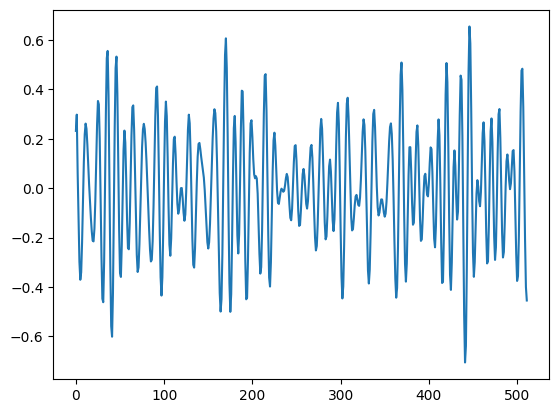

In [11]:
RSAD.trainer.training = True
RSAD.trainer.validating = False
ds = RSAD.train_dataloader()
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        X, waveforms = batch
        batch = (X.to(torch.device('cuda:0')), waveforms.to(torch.device('cuda:0')))
        del X, waveforms
        batch = RSAD.on_after_batch_transfer(batch, 10)
        X, waveforms = batch
        break
plt.plot(X[0][0][:512].cpu().numpy())

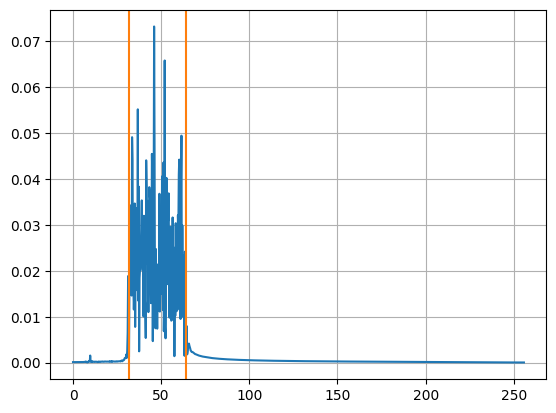

In [12]:
from scipy.fft import fft, fftfreq
import numpy as np
N = 2048
T = 1.0 / 512.0
yf = fft(X[0][0].cpu().numpy())
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(32, c = 'C1')
plt.axvline(64, c = 'C1')
plt.grid()
plt.show()

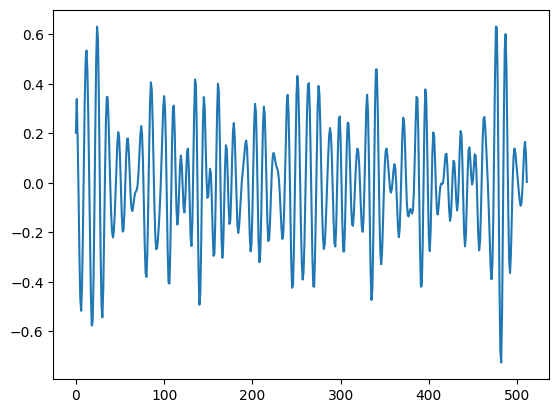

In [24]:
RSAD.trainer.training = False
RSAD.trainer.validating = True
ds = RSAD.val_dataloader()
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        [background, _, timeslide_idx], [signals] = batch
        batch = [background.to(torch.device('cuda:0')), 0, timeslide_idx], [signals.to(torch.device('cuda:0'))]
        del background, timeslide_idx, signals
        batch = RSAD.on_after_batch_transfer(batch, 10)
        shift, X_bg, X_inj = batch
        break
plt.plot(X_inj[0][0][0][:512].cpu().numpy())

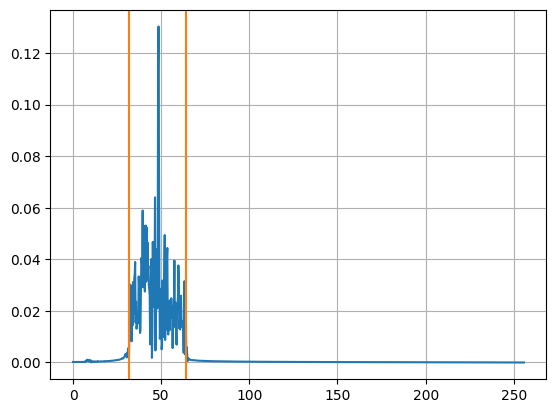

In [15]:
from scipy.fft import fft, fftfreq
import numpy as np
N = 2048
T = 1.0 / 512.0
yf = fft(X_inj[0][0][0].cpu().numpy())
xf = fftfreq(N, T)[:N//2]
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.axvline(32, c = 'C1')
plt.axvline(64, c = 'C1')
plt.grid()
plt.show()

In [16]:
RSAD.trainer.training = False
RSAD.trainer.validating = True
ds = RSAD.val_dataloader()

i = 0
metric = TimeSlideAUROC(max_fpr = 1e-3, pool_length = 8, stride = 0.5)
with torch.no_grad():
    for batch in ds:
        batch = RSAD.on_before_batch_transfer(batch, 10)
        [background, _, timeslide_idx], [signals] = batch
        batch = [background.to(torch.device('cuda:0')), 0, timeslide_idx], [signals.to(torch.device('cuda:0'))]
        del background, timeslide_idx, signals
        batch = RSAD.on_after_batch_transfer(batch, 10)
        shift, X_bg, X_inj = batch
        del batch
        y_bg = module.score(X_bg)
        del X_bg
        num_views, batch, *shape = X_inj.shape
        X_inj = X_inj.view(num_views * batch, *shape)
        
        y_fg = module.score(X_inj)
        y_fg = y_fg.view(num_views, batch)
        del num_views, batch, shape
        y_fg = y_fg.mean(0)
        y_bg = y_bg.cpu()
        y_fg = y_fg.cpu()
        metric.update(shift, y_bg.cpu(), y_fg.cpu())
        i += 1
        if i > 10:
            break

In [18]:
foreground, background = [], defaultdict(list)
for i, bg, fg in zip(metric.shifts, metric.background, metric.foreground):
    foreground.append(fg)
    background[i.item()].append(bg)
foreground = torch.cat(foreground)

In [19]:
pooled_background = []
for bg in background.values():
    bg = torch.cat(bg).view(1, 1, -1)
    bg = metric.pool(bg).view(-1)
    pooled_background.append(bg)
background = torch.cat(pooled_background)

In [20]:
y_pred = torch.cat([background, foreground])
y = torch.zeros_like(y_pred)
y[len(background) :] = 1
idx = torch.randperm(len(y_pred))
y_pred = y_pred[idx]
y = y[idx]

In [22]:
metric.metric(y_pred, y)

tensor(0.4997)

In [23]:
foreground

tensor([0.3513, 0.3519, 0.3506, 0.3520, 0.3491, 0.3486, 0.3455, 0.3477, 0.3468,
        0.3435, 0.3397, 0.3462, 0.3458, 0.3455, 0.3452, 0.3444, 0.3466, 0.3385,
        0.3427, 0.3419, 0.3409, 0.3451, 0.3449, 0.3460, 0.3444, 0.3484, 0.3460,
        0.3280, 0.3488, 0.3502, 0.3494, 0.3419, 0.3527, 0.3480, 0.3523, 0.3521,
        0.3470, 0.3413, 0.3505, 0.3482, 0.3491, 0.3490, 0.3470, 0.3461, 0.3437,
        0.3487, 0.3415, 0.3480, 0.3491, 0.3484, 0.3519, 0.3381, 0.3521, 0.3521,
        0.3537, 0.3495, 0.3499, 0.3504, 0.3482, 0.3480, 0.3499, 0.3499, 0.3518,
        0.3507, 0.3505, 0.3487, 0.3514, 0.3492, 0.3454, 0.3468, 0.3472, 0.3423,
        0.3469, 0.3458, 0.3466, 0.3466, 0.3470, 0.3494, 0.3471, 0.3484, 0.3450,
        0.3453, 0.3476, 0.3463, 0.3443, 0.3484, 0.3443, 0.3464, 0.3457, 0.3458,
        0.3466, 0.3457, 0.3471, 0.3487, 0.3499, 0.3469, 0.3478, 0.3481, 0.3472,
        0.3492, 0.3511, 0.3493, 0.3480, 0.3520, 0.3532, 0.3544, 0.3558, 0.3547,
        0.3463, 0.3528])

In [21]:
y

tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       device='cuda:0')